In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 28.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp39-cp39-linux_x86_64.whl size=61826133 sha256=1b915af99f173cc304bbf8f09e93912aee5617e8ea99513f382e4b19581193b5
  Stored in directory: /root/.cache/pip/wheels/b8/36/bf/7ec7e363f796373cea3eb9ea94e83f5bbbb586d2edbf7e3417
Successfully built pystan
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=9436475 sha256=9dc3374d93e0588140365e88914dd2e0263ce03339d771853f5881902a095a6c
  Stored in directory: /root/.cache/pip/wheels/da/a4/bb/dbed5db92b2183a753dd96cc8a56706a61484ff3959988

# Getting the data

In [6]:
from fbprophet import Prophet

!mkdir -p dataset
!wget -c -b http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt -P dataset


Continuing in background, pid 7482.
Output will be written to ‘wget-log.1’.


In [7]:
data = np.loadtxt("dataset/sunspots.txt", float)

In [8]:
data

array([[0.000e+00, 5.800e+01],
       [1.000e+00, 6.260e+01],
       [2.000e+00, 7.000e+01],
       ...,
       [3.140e+03, 2.520e+01],
       [3.141e+03, 2.350e+01],
       [3.142e+03, 2.160e+01]])

### Converting data to Pandas dataframe

In [9]:
data_as_frame = pd.DataFrame(data, columns=['Months', 'SunSpots'])
data_as_frame.tail(10)

,Months,SunSpots
3133,3133.0,18.8
3134,3134.0,15.4
3135,3135.0,8.0
3136,3136.0,8.7
3137,3137.0,13.6
3138,3138.0,16.1
3139,3139.0,19.6
3140,3140.0,25.2
3141,3141.0,23.5
3142,3142.0,21.6


In [10]:
data_as_frame['ds']=data_as_frame['Months'].astype(int)

In [11]:
data_as_frame.head()

,Months,SunSpots,ds
0,0.0,58.0,0
1,1.0,62.6,1
2,2.0,70.0,2
3,3.0,55.7,3
4,4.0,85.0,4


In [12]:
 data_as_frame['time_stamp']= \
  data_as_frame.apply(lambda x:(pd.Timestamp('1749-01-01')+pd.DateOffset(months = int(x['ds']))),axis=1)

In [13]:
data_as_frame

,Months,SunSpots,ds,time_stamp
0,0.0,58.0,0,1749-01-01
1,1.0,62.6,1,1749-02-01
2,2.0,70.0,2,1749-03-01
3,3.0,55.7,3,1749-04-01
4,4.0,85.0,4,1749-05-01
...,...,...,...,...
3138,3138.0,16.1,3138,2010-07-01
3139,3139.0,19.6,3139,2010-08-01
3140,3140.0,25.2,3140,2010-09-01
3141,3141.0,23.5,3141,2010-10-01


In [14]:
#Cleaning the df, we only need two columns date time and the data
clean_df=data_as_frame.drop(['Months','ds'],axis=1)

In [15]:
clean_df.head()

,SunSpots,time_stamp
0,58.0,1749-01-01
1,62.6,1749-02-01
2,70.0,1749-03-01
3,55.7,1749-04-01
4,85.0,1749-05-01


<AxesSubplot:xlabel='time_stamp'>

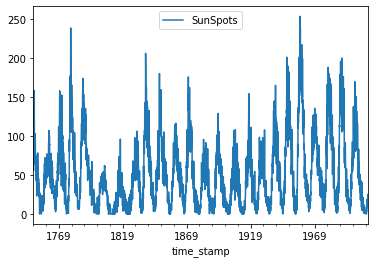

In [16]:
clean_df.set_index('time_stamp').plot()

# Preparing data for modelling in Prophet

In [17]:
## Prophet requires two columns, one is ds (the date time) and y (variable to be forecasted)
clean_df.columns = ['y', 'ds']

In [18]:
clean_df

,y,ds
0,58.0,1749-01-01
1,62.6,1749-02-01
2,70.0,1749-03-01
3,55.7,1749-04-01
4,85.0,1749-05-01
...,...,...
3138,16.1,2010-07-01
3139,19.6,2010-08-01
3140,25.2,2010-09-01
3141,23.5,2010-10-01


## Lets Predict

Displaying Prophet plot


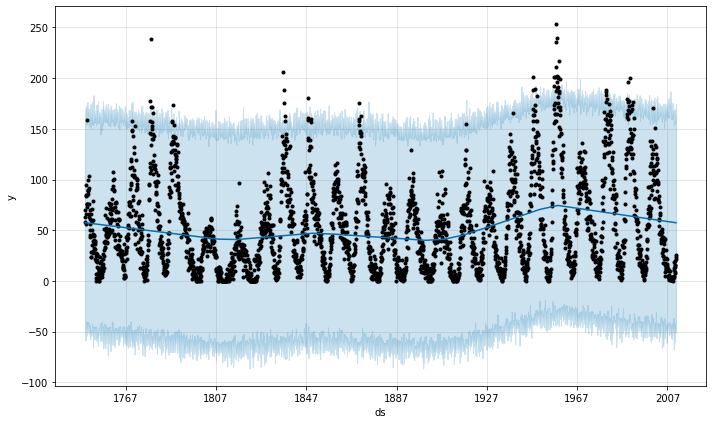

In [19]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    
    forecast = m.predict(dataframe) # 예측 값 <=> 실제 값을 비교
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    return forecast
    
pred = fit_predict_model(clean_df)


In [20]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,fact
0,1749-01-01,57.445255,-57.085757,169.287189,57.445255,57.445255,0.0,0.0,0.0,0.0,0.0,0.0,57.445255,58.0
1,1749-02-01,57.421769,-49.678851,153.580536,57.421769,57.421769,0.0,0.0,0.0,0.0,0.0,0.0,57.421769,62.6
2,1749-03-01,57.400555,-49.281934,165.844345,57.400555,57.400555,0.0,0.0,0.0,0.0,0.0,0.0,57.400555,70.0
3,1749-04-01,57.377069,-58.637671,160.469467,57.377069,57.377069,0.0,0.0,0.0,0.0,0.0,0.0,57.377069,55.7
4,1749-05-01,57.354340,-51.026030,161.258343,57.354340,57.354340,0.0,0.0,0.0,0.0,0.0,0.0,57.354340,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,2010-07-01,57.446697,-44.484833,155.964102,57.446697,57.446697,0.0,0.0,0.0,0.0,0.0,0.0,57.446697,16.1
3139,2010-08-01,57.418935,-51.632955,164.842067,57.418935,57.418935,0.0,0.0,0.0,0.0,0.0,0.0,57.418935,19.6
3140,2010-09-01,57.391174,-40.925600,157.245690,57.391174,57.391174,0.0,0.0,0.0,0.0,0.0,0.0,57.391174,25.2
3141,2010-10-01,57.364308,-49.345967,169.682343,57.364308,57.364308,0.0,0.0,0.0,0.0,0.0,0.0,57.364308,23.5


In [21]:
pred[['ds', 'yhat_lower', 'yhat_upper', 'fact']]

,ds,yhat_lower,yhat_upper,fact
0,1749-01-01,-57.085757,169.287189,58.0
1,1749-02-01,-49.678851,153.580536,62.6
2,1749-03-01,-49.281934,165.844345,70.0
3,1749-04-01,-58.637671,160.469467,55.7
4,1749-05-01,-51.026030,161.258343,85.0
...,...,...,...,...
3138,2010-07-01,-44.484833,155.964102,16.1
3139,2010-08-01,-51.632955,164.842067,19.6
3140,2010-09-01,-40.925600,157.245690,25.2
3141,2010-10-01,-49.345967,169.682343,23.5


# Detecting Anomalies:
* The light blue boundaries in the above graph are yhat_upper and yhat_lower.
* If y value is greater than yhat_upper and less than yhat lower then it is an anomaly.
* Also getting the importance of that anomaly based on its distance from yhat_upper and yhat_lower.

In [22]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] == 1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [23]:
pred

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,1749-01-01,57.445255,57.445255,-57.085757,169.287189,58.0,0,0.0
1,1749-02-01,57.421769,57.421769,-49.678851,153.580536,62.6,0,0.0
2,1749-03-01,57.400555,57.400555,-49.281934,165.844345,70.0,0,0.0
3,1749-04-01,57.377069,57.377069,-58.637671,160.469467,55.7,0,0.0
4,1749-05-01,57.354340,57.354340,-51.026030,161.258343,85.0,0,0.0
...,...,...,...,...,...,...,...,...
3138,2010-07-01,57.446697,57.446697,-44.484833,155.964102,16.1,0,0.0
3139,2010-08-01,57.418935,57.418935,-51.632955,164.842067,19.6,0,0.0
3140,2010-09-01,57.391174,57.391174,-40.925600,157.245690,25.2,0,0.0
3141,2010-10-01,57.364308,57.364308,-49.345967,169.682343,23.5,0,0.0


In [24]:
pred[pred['anomaly'] == 1]

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
10,1749-11-01,57.214935,57.214935,-45.865510,154.589146,158.6,1,0.025289
347,1777-12-01,49.443886,49.443886,-46.995444,154.615815,157.3,1,0.017064
348,1778-01-01,49.420399,49.420399,-48.941792,169.153411,177.3,1,0.045948
352,1778-05-01,49.329482,49.329482,-66.187891,149.858822,238.9,1,0.372713
353,1778-06-01,49.305995,49.305995,-54.684618,154.219056,171.6,1,0.101288
...,...,...,...,...,...,...,...,...
2899,1990-08-01,63.960808,63.960808,-41.212589,170.799464,200.3,1,0.147282
2905,1991-02-01,63.796029,63.796029,-46.539634,166.414627,167.5,1,0.006480
2910,1991-07-01,63.661699,63.661699,-41.438941,171.410138,173.7,1,0.013183
2911,1991-08-01,63.633938,63.633938,-42.256165,167.444159,176.3,1,0.050232
